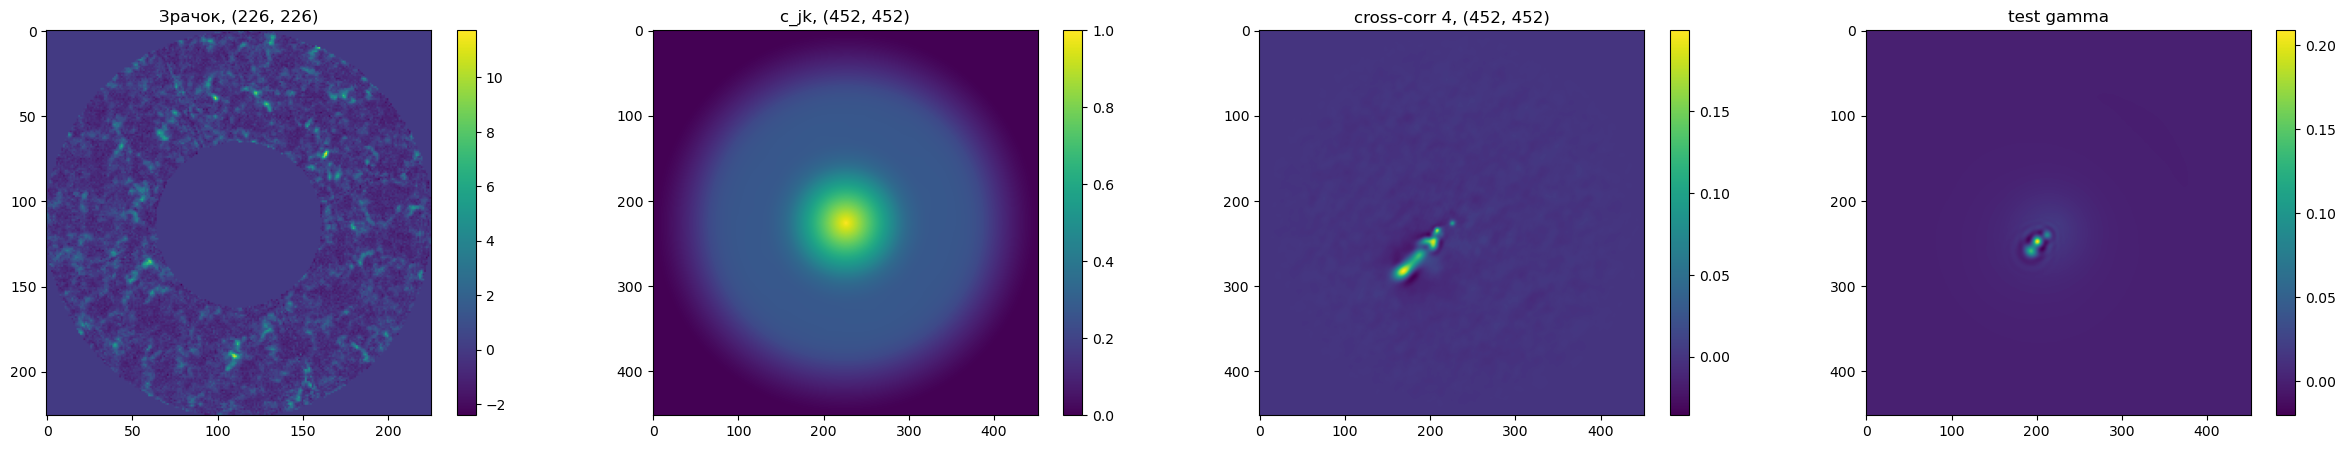

In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from skimage.filters import threshold_multiotsu, threshold_otsu, median

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] > value:
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx

def gamma_poly_se(X, Y, Vx, Vy, Cn2, z):
    global cjk, t, a1, gammas, delta
    
    z=z*1000
    Cn2=Cn2*1e-14
    
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest(a1, z)[1]
    uv = find_nearest(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    
    res = (res/(1e-13))*Cn2
    res = shift(res, (-Ypix, Xpix), order=1)  

    res = res * cjk
    return res

# ----------- входные параметры
D = 2.5
latency = 4
data_dir = 'D:/astro/domecam'
lambda_=500*pow(10, -9) # нм


sec_per_frame = 0.01
t = sec_per_frame * latency
k = 2*np.pi/lambda_

# ---------- считывание зрачка, картины мерцаний, автокорреляции зрачка и гамм

pupil = np.loadtxt(f'{data_dir}/frame.gz')
data = np.loadtxt(f'{data_dir}/data_corr4.gz')
cjk = np.loadtxt(f'{data_dir}/cjk.gz')
gammas = np.load(f'{data_dir}/gammas.npy')
test_gamma = np.loadtxt(f'{data_dir}/test_gamma.gz')
a1 = np.loadtxt(f'{data_dir}/z.gz')

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

delta = D/(pupil.shape[0]) # шаг по пикселю

# ------------------ распределение гамм


fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr 4, {data.shape}')

fig.colorbar(ax4.imshow(test_gamma), ax=ax4)
ax4.grid(False)
ax4.set_title(f'test gamma')

def CLEAN(dirty, gain=None, thresh=None, niter=None):
    global t, delta
    st = time.perf_counter()
    comps = np.zeros(dirty.shape)
    res = np.array(dirty) 
    cl = np.zeros(dirty.shape)
    
    k = 3
    res2 = np.array(dirty)
    cl2 = np.zeros(dirty.shape)

    tmp = 0
    tmp_Vx = []
    tmp_Vy = []
    all_params = []
    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res), res.shape)
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
        
        tmp_Vx.append(Vx)
        tmp_Vy.append(Vy)
                
        if i > 5\
        and tmp_Vx[i-4] == tmp_Vx[i] and tmp_Vx[i-3] == tmp_Vx[i] and tmp_Vx[i-2] == tmp_Vx[i] and tmp_Vx[i-1] == tmp_Vx[i]\
        and tmp_Vy[i-4] == tmp_Vy[i] and tmp_Vy[i-3] == tmp_Vy[i] and tmp_Vy[i-2] == tmp_Vy[i] and tmp_Vy[i-1] == tmp_Vy[i]:
            all_params = np.array(all_params)
            all_params = all_params[:-4, :]
            print('Stucked')
            break
        
        if int(Vx) == 0 and int(Vy) == 0:
            myParams = [0, 0, 8.9, 2]
            psf, params = multi_speckle_fit(myParams, ydata=res, window=5)
            print('-initial value:', res[my, mx])
            res -= psf*0.99
        else:
            myParams = [Vx, Vy, 1, 15+5*np.sin(np.random.uniform(-np.pi, np.pi))]  
            psf, params = multi_speckle_fit(myParams, ydata=res, window=20)
            print('-initial value:', res[my, mx])
            res -= psf*gain
        
        cl += psf*gain
        all_params.append(params)
        print('-residual value:', res[my, mx])
        
        if (i+1)%k == 0:
            print('\nCheckpoint fitting...')
#             fit, params2 = one_speckle_fit(all_params[i-(k-1):i+1], res2)
#             res2 -= fit
#             cl2 += fit
        print(' ')
        
        tmp = i
        if np.max(res) < thresh:
            print('Thresh reached!')
            break
    print('Total iterations:', tmp+1)
    print('time:', time.perf_counter()-st)
    return comps, res, cl, np.array(all_params)


def multi_speckle_fit(params, ydata=None, window=None):
    global t, delta
    st=time.perf_counter()  
    def speckle_fit(params, ydata):
        k=window
        def _g(one_dim_x, *args): 
            arr = np.zeros(one_dim_x[0].shape)
            Vx = args[0]
            Vy = args[1]
            Cn2 = args[2]
            z = args[3]
            arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], Vx, Vy, Cn2, z)[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
            return arr
        
        xcoord = params[0]
        ycoord = params[1]
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
        
        fit = np.zeros(ydata.shape)
        ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
        
        plt.figure()
        plt.imshow(ydata)
        plt.colorbar()
        plt.show()
        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)
        
        xdata = np.vstack((X.ravel(), Y.ravel()))
        
        ydata = ydata.ravel()

        bounds = [[-np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf]]
        popt, pcov = curve_fit(_g, xdata, ydata, p0=params, bounds=bounds)
        
#         fit += gamma_poly_se(X, Y, *popt)[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k] 
        fit += gamma_poly_se(X, Y, *popt)        

        
#         plt.figure()
#         plt.imshow(fit)
#         plt.colorbar()
#         plt.show()
        
#         residual = np.sum((np.resize(ydata, (2*k, 2*k))-fit)**2)
#         residual2 = np.sum((np.resize(ydata, (2*k, 2*k))-test)**2)
#         print(f'fitted resid:{residual} manual:{residual2}')

        return fit, popt[0], popt[1], popt[2], popt[3]
        
    res = np.zeros(data.shape)
    print(f'Speckle fitting: {params[0]} {params[1]} {1e-14*params[2]} {1000*params[3]}')
    fit, Vx, Vy, Cn2, z = speckle_fit(params, ydata)
    
    xcoord = int(Vx*t/delta)
    ycoord = int(Vy*t/delta)
    res +=fit
#     res[(res.shape[0]//2 - ycoord) - fit.shape[0]//2:(res.shape[0]//2 - ycoord) + fit.shape[0]//2, 
#             (res.shape[1]//2 + xcoord) - fit.shape[1]//2:(res.shape[1]//2 + xcoord) + fit.shape[1]//2] += fit
        
    print(f'Fitted parametrs: {Vx:.2f} {Vy:.2f} {1e-14*Cn2} {1000*z}')
    print('time:', time.perf_counter()-st)    
    return res, [Vx, Vy, Cn2, z]

def one_speckle_fit(params=None, data=None): 
    def _g(M, *args): 
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//4):
            arr += gamma_poly_se(x, y, *args[i*4:i*4+4]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) 
    xdata = np.vstack((X.ravel(), Y.ravel())) 
    ydata = data.ravel()
        
    lb = [-np.inf, -np.inf, 0, 2000]
    lb = np.tile(lb, len(p0)//4)
    ub = [np.inf, np.inf, np.inf, np.inf]
    ub = np.tile(ub, len(p0)//4)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])

    for i in range(len(popt)//4):
        fit += gamma_poly_se(X, Y, *popt[i*4:i*4+4])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//4):
        print(*popt[i*4:i*4+4])

    return fit, popt

Speckle fitting: -15.763274336283187 -15.486725663716813 1e-14 10566.292276630864


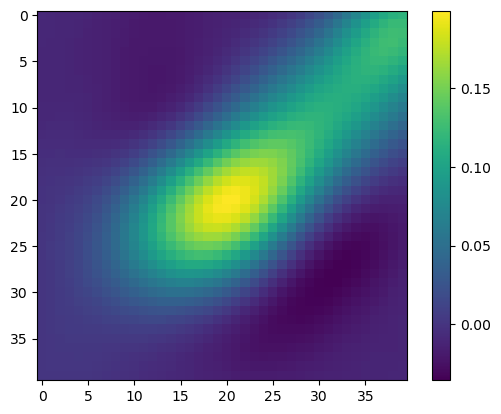

Fitted parametrs: -15.59 -15.02 1.739011127451031e-14 61486.67930614751
time: 1.2171943999999257
-initial value: 0.1994432949828054
-residual value: 0.06791800990937055
 
Speckle fitting: -6.084070796460177 -6.084070796460177 1e-14 10106.33810499019


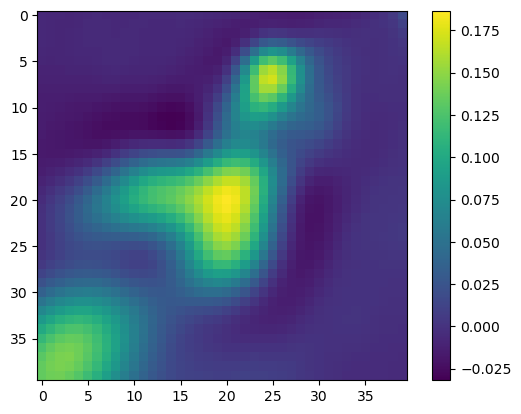

Fitted parametrs: -6.76 -6.22 7.290026750115831e-15 53144.002371237446
time: 1.329500699999926
-initial value: 0.18669135436071796
-residual value: 0.08209160616913018
 
Speckle fitting: -4.701327433628318 -2.4889380530973453 1e-14 15924.756101987387


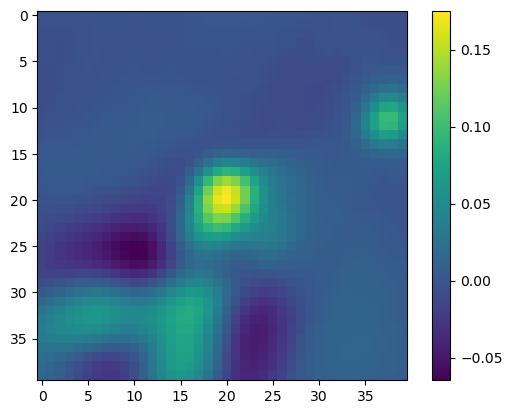

Fitted parametrs: -4.79 -2.45 3.25721573564586e-14 10212.559480323325
time: 0.6041531999999279
-initial value: 0.17526837275169377
-residual value: 0.05778461087515281

Checkpoint fitting...
 
Speckle fitting: -10.785398230088495 -10.785398230088495 1e-14 19867.401571943108


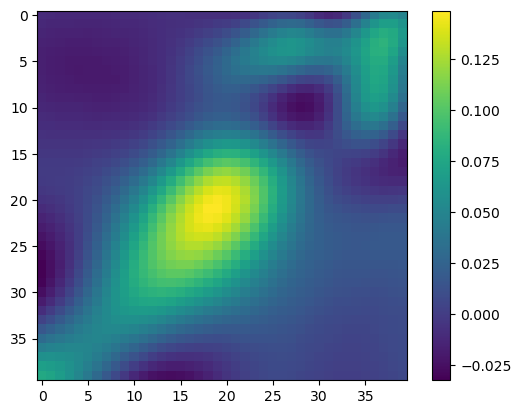

Fitted parametrs: -11.46 -11.39 1.1082551153217748e-14 54590.86568729684
time: 0.49401769999997214
-initial value: 0.14858342588886456
-residual value: 0.04680825197578378
 
Speckle fitting: 0 0 8.9e-14 2000


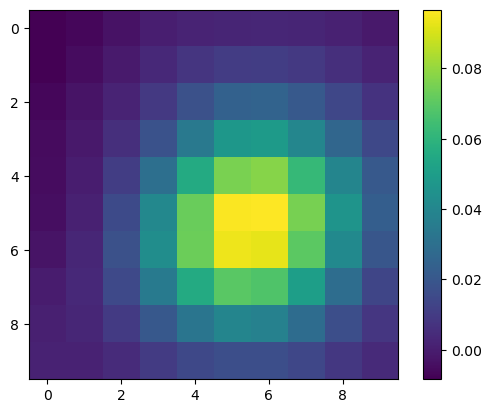

Fitted parametrs: 0.02 0.05 4.6194854121349476e-14 4256.698261850371
time: 0.5462638999999854
-initial value: 0.09669656574040766
-residual value: 0.007512734043796612
 
Speckle fitting: -16.5929203539823 -16.316371681415927 1e-14 17346.23916546647


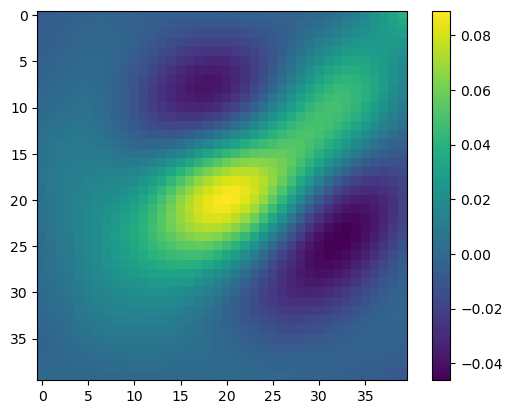

Fitted parametrs: -17.24 -16.42 1.6993723864622072e-14 31870.669073373196
time: 0.8943715999999995
-initial value: 0.0890384589005661
-residual value: 0.024622687031407076

Checkpoint fitting...
 
Speckle fitting: -5.807522123893805 -5.807522123893805 1e-14 14684.655033005798


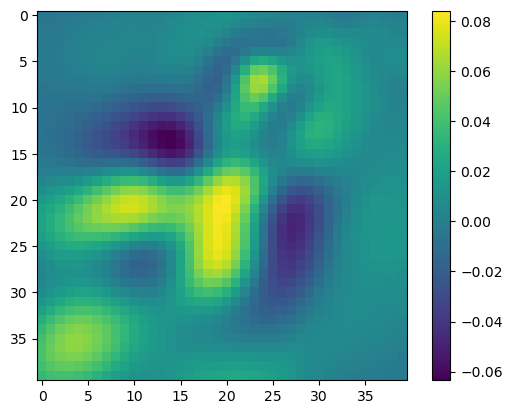

Fitted parametrs: -6.54 -6.40 1.541733040416012e-14 15662.791139413916
time: 0.7517907999999807
-initial value: 0.08406650863779033
-residual value: 0.03412949640063414
 
Speckle fitting: -8.849557522123893 -6.084070796460177 1e-14 13028.43187442142


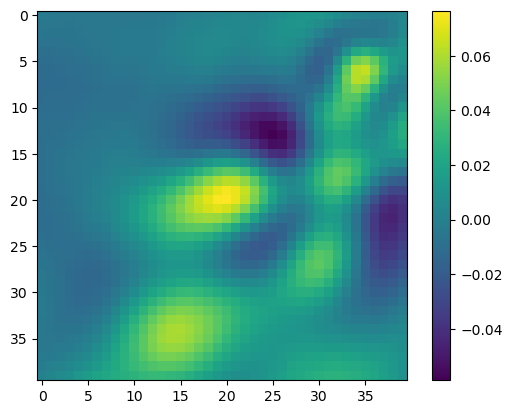

Fitted parametrs: -9.49 -5.99 2.4030580351785108e-14 9860.734741886166
time: 0.672916999999984
-initial value: 0.0765525144022782
-residual value: 0.022516245642607804
 
Speckle fitting: -4.701327433628318 -2.2123893805309733 1e-14 14133.540961969931


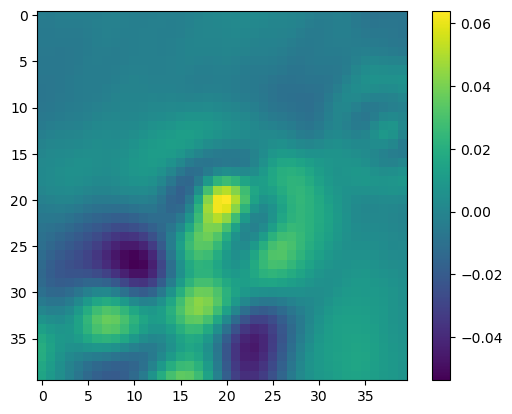

Fitted parametrs: -3.93 -2.79 1.8279183966584414e-15 34620.07580431496
time: 0.9260555999999269
-initial value: 0.06406526937844088
-residual value: 0.04815694129724425

Checkpoint fitting...
 
Speckle fitting: -10.232300884955752 -9.955752212389381 1e-14 13219.774932440945


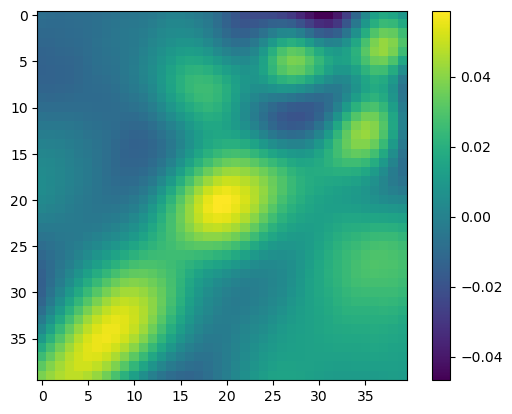

Fitted parametrs: -10.43 -9.97 1.2726256333506324e-14 16783.816290248447
time: 0.41256319999990865
-initial value: 0.058899436192572596
-residual value: 0.011256125262807892
 
Speckle fitting: -13.827433628318584 -14.103982300884956 1e-14 11037.089670571444


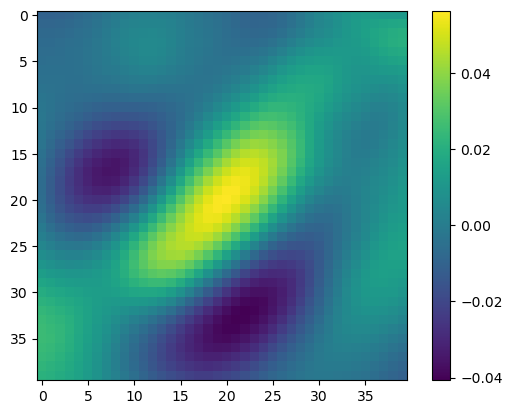

Fitted parametrs: -13.94 -13.73 1.204878488432487e-14 25711.92287652462
time: 1.1279574999999795
-initial value: 0.05638114530608045
-residual value: 0.010305741825111056
 
Thresh reached!
Total iterations: 11
time: 9.002709400000072


Text(0.5, 1.0, 'max: 0.0485, min: -0.0521')

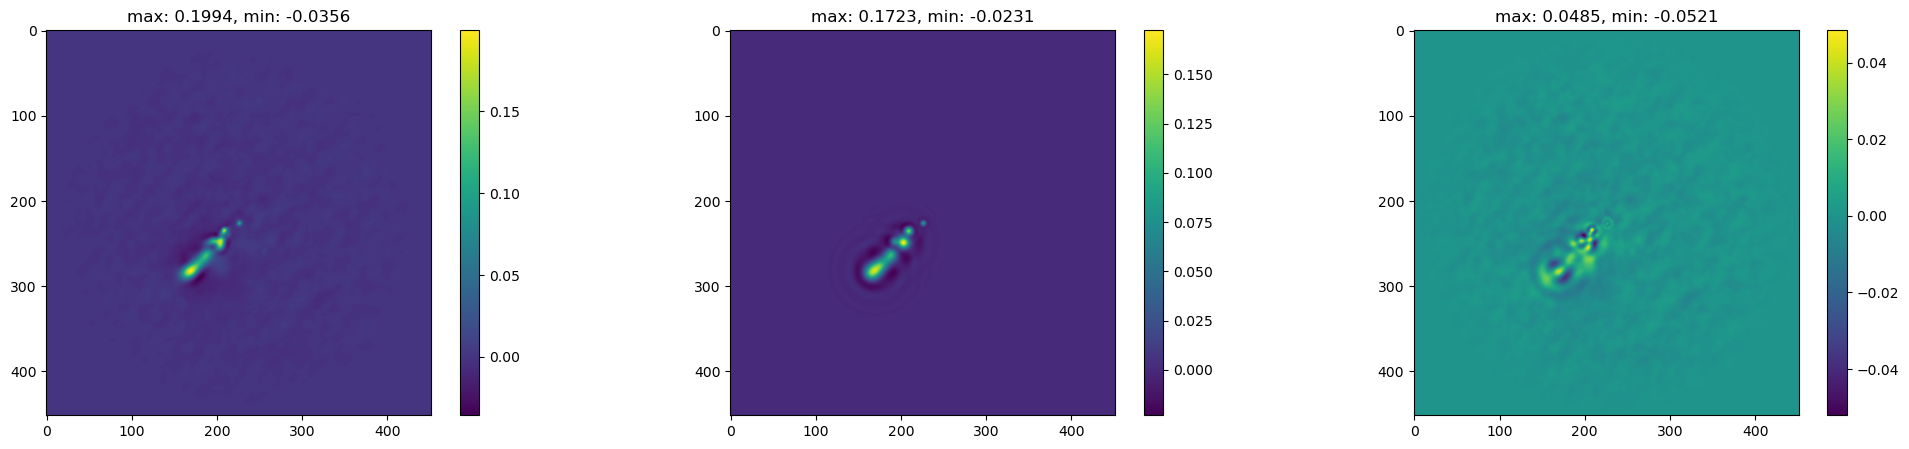

In [11]:
comps, residual, clean, params = CLEAN(data, gain=0.8, thresh=threshold_otsu(data), niter=100)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data), ax=ax) 
fig.colorbar(ax2.imshow(clean), ax=ax2) 
fig.colorbar(ax3.imshow(residual), ax=ax3) 
ax.set_title(f'max: {np.max(data):.4f}, min: {np.min(data):.4f}') 
ax2.set_title(f'max: {np.max(clean):.4f}, min: {np.min(clean):.4f}') 
ax3.set_title(f'max: {np.max(residual):.4f}, min: {np.min(residual):.4f}')

In [ ]:
k_height=150
k_width=20
R=np.zeros((k_height, k_width))
h = np.linspace(0, 10000, k_height)
c = np.geomspace(1e-14, 1e-11, k_width)
for i in range(k_height):
    for j in range(k_width):
        R[i, j] = np.sum(pow(data - gamma_poly_se(X, Y, 0, 0, c[j], h[i]), 2)[211:241,211:241])

plt.imshow(np.log(R), vmin=-8, vmax=-6)
plt.scatter(np.unravel_index(np.argmin(R), R.shape)[1], np.unravel_index(np.argmin(R), R.shape)[0], color='red', s=5)
plt.colorbar()
print(R[np.unravel_index(np.argmin(R), R.shape)], np.unravel_index(np.argmin(R), R.shape))
print(h[39], c[6])

#двумерная карта невязки, где по осям ОУ размечено разбиение по высотам, а по ОХ - разбиение по мощности. в каждой ячейке
# матрицы содержится значение R = sum(data-model)^2. Видно, что при меньшем окне при подсчете суммы, невязка принимает
# правильное значение минимума. В то время как при подсчете в полном окне, минимум явно не прослеживается и поэтому 
# минимизация выдает такое значение

# короче: дальше мне нужно реализовать КЛИН с использованием окна

In [ ]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 

all_cn2 = []
for i in range(params.shape[0]):
    all_cn2.append(params[i][2])
    
sum_cn2 = np.sum(all_cn2)
lambda_ = 500 * pow(10, -9)
r0 = pow(0.423 * pow((2*np.pi/lambda_), 2) * sum_cn2, -3/5)
seeing = 206265 * 0.98 * lambda_/r0

for i in params:
    ax.scatter(i[3], i[2])
    ax2.scatter(i[3], i[1])
    ax3.scatter(i[3], i[0])
ax.set_title('Cn2/z')
ax2.set_title('Vy/z')
ax3.set_title('Vx/z')
ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
fig.text(0.12, -0.1, f'\nCn2: {sum_cn2}\nlambda: {lambda_}\nr0: {r0:.4f}\nseeing: {seeing:.4f}')
fig.suptitle('20210130l_m2km, latency = 4')
# fig.savefig('D:/astro/profile1.png', bbox_inches='tight')
print('')

In [ ]:
params
new_params = params.copy()

new_params[:, 0] = np.vectorize(int)(new_params[:, 0])
new_params[:, 1] = np.vectorize(int)(new_params[:, 1])
new_params[:, 3] = np.vectorize(int)(new_params[:, 3])

new_params2 = []
for i in range(new_params.shape[0]):
    vx = new_params[i][0]
    vy = new_params[i][1]
    tmp=[]
    for j in range(new_params.shape[0]):
        if vx == new_params[j][0] and vy == new_params[j][1]:
            tmp.append(new_params[j])
    tmp = np.array(tmp)
    new_params2.append(np.mean(tmp, axis=0))
    del tmp
    
new_params2 = np.unique(np.array(new_params2), axis=0)
print('initial params:', new_params.shape, '\ncleaned params:', new_params2.shape)
print(new_params2)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
for i in new_params2:
    ax.scatter(i[3], i[2])
    ax2.scatter(i[3], i[1])
    ax3.scatter(i[3], i[0])
ax.set_title('Cn2/z')
ax2.set_title('Vy/z')
ax3.set_title('Vx/z')
ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

In [ ]:
# params

fit, params2 = one_speckle_fit(params[0:3], data)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data), ax=ax) 
fig.colorbar(ax2.imshow(fit), ax=ax2) 
fig.colorbar(ax3.imshow(data-fit), ax=ax3) 

In [ ]:
p3 = np.reshape(params2, (-1, 4))
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
for i in p3:
    ax.scatter(i[3], i[2])
    ax2.scatter(i[3], i[1])
    ax3.scatter(i[3], i[0])
ax.set_title('Cn2/z')
ax2.set_title('Vy/z')
ax3.set_title('Vx/z')
ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

p3